In [17]:
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import matplotlib as mpl
from matplotlib.colors import ListedColormap ,LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
from matplotlib.collections import PolyCollection
from scipy.spatial import KDTree
%xmode Plain

Exception reporting mode: Plain


In [18]:
def sph_to_cart(phi,theta): #for r = 1
    return np.array([np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)])

def cart_to_sph(x,y,z):
    return np.array([np.arctan2(y,x),np.arctan2(np.sqrt(x**2+y**2),z)])

def fresnel_s(theta_i): #from space/air to water
    return abs((np.cos(theta_i)-1.33*np.sqrt(1-(1/1.33*np.sin(theta_i))**2))/(np.cos(theta_i)+(1.33*np.sqrt(1-(1/1.33*np.sin(theta_i))**2))))**2



In [19]:
numpoints = 1001
seed_no = 0
alts = np.loadtxt('alts/alts_'+str(seed_no)+'n'+str(numpoints)+'.txt',delimiter=',')
voronoi_grid = np.loadtxt('voronoi_grid_n'+str(numpoints),delimiter=',')
plot_facets_vor = np.load('plot_facets_n'+str(numpoints)+'.npy',allow_pickle=',')
phi_grid,theta_grid,area_grid = voronoi_grid.transpose()

alts = alts-np.mean(alts)
max_alt = max(alts)
min_alt = min(alts)
# norm_alts = (alts-min_alt)/(max_alt-min_alt)
snowheight = 0.8
soilheight = 0.4
waterheight = 0

albedo_map = np.zeros(3*numpoints) #ocean

for i in range(numpoints):
    if alts[i] >= snowheight*max_alt:#snow
        albedo_map[i] = 0.6+(alts[i]-snowheight*max_alt)/(max_alt-snowheight*max_alt)*0.3
    elif alts[i] < 0.0: #water
        albedo_map[i+2*numpoints] = 1
    elif (alts[i] >= soilheight*max_alt and alts[i]<snowheight*max_alt): #soil
        albedo_map[i+numpoints] = 0.3+(alts[i]-soilheight*max_alt)/(snowheight*max_alt-soilheight*max_alt)*0.2
    elif (alts[i] >= waterheight*max_alt and alts[i]<soilheight*max_alt): #forest
        albedo_map[i] = 0.1+(alts[i]-waterheight*max_alt)/(soilheight*max_alt-waterheight*max_alt)*0.2 

models = ('lambert','LomSee','water')


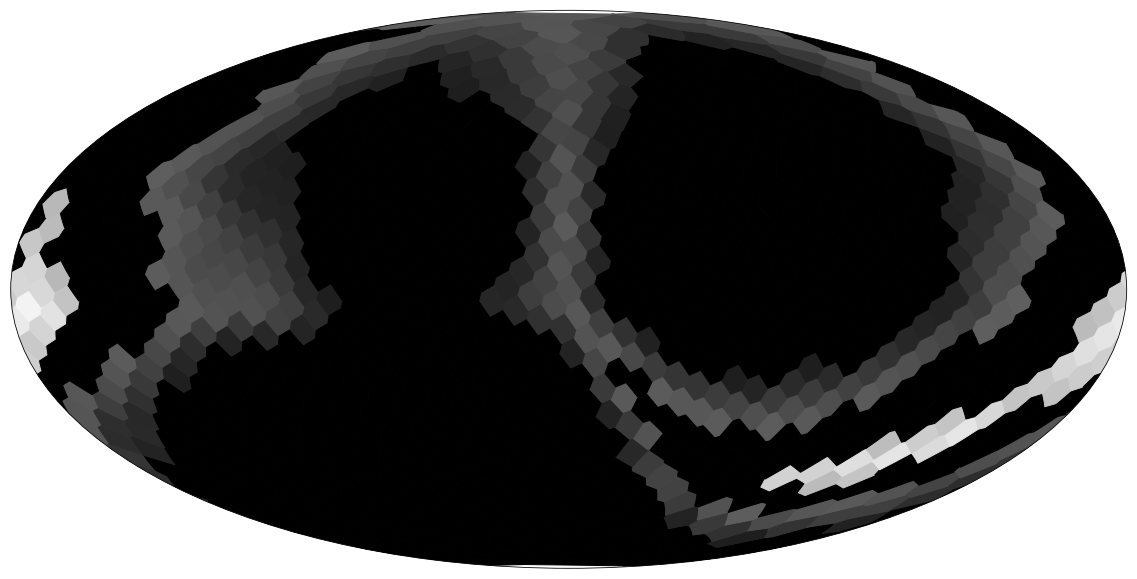

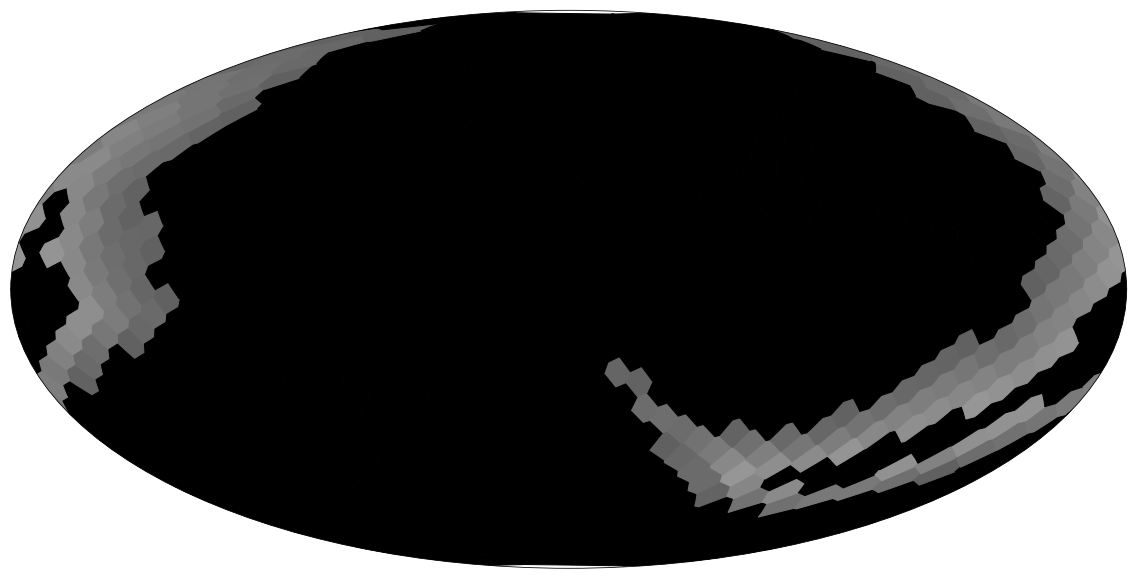

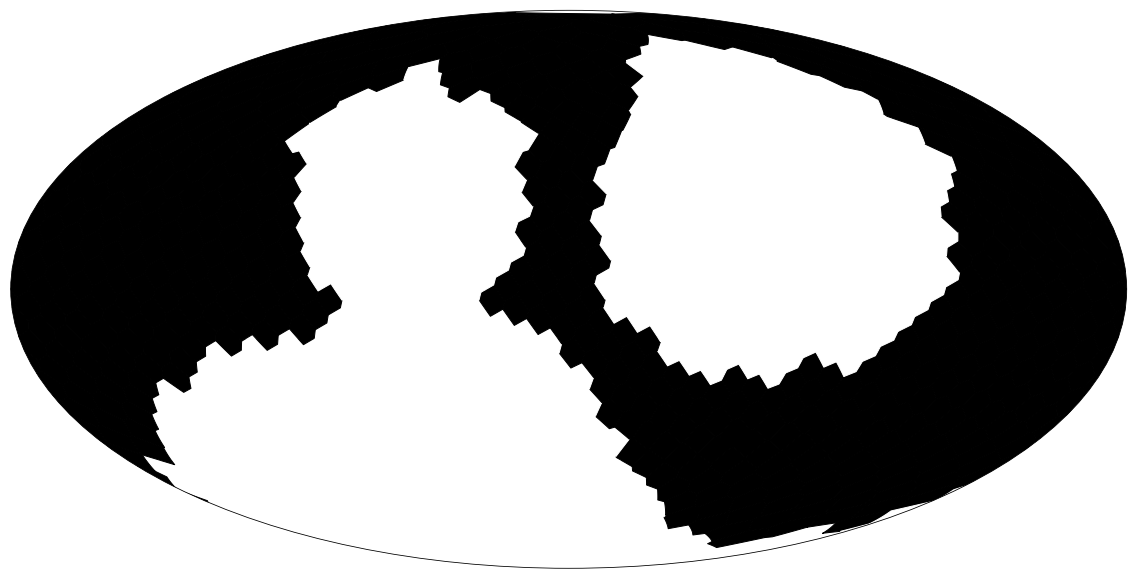

Wall time: 10.2 s


In [20]:
%%time
# plot each map, lambertian, lomsee and fresnel
mpl.rcParams.update({'font.size': 26})
greys = mpl.cm.get_cmap('Greys_r',4000) #colors

fig1 = plt.figure(figsize = [20,20])
ax1 = fig1.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
cmapplot.set_array([])
# cb = fig1.colorbar(cmapplot, ax=ax1, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax1.add_collection(PolyCollection(plot_facets_vor,array=albedo_map[:numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets
i=0
for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = greys(albedo_map[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax1.set_xticklabels([])
ax1.set_yticklabels([])
model = models[0]
filename = 'albedo_maps_spectrMultRefl/spectrseed'+str(seed_no)+'_model'+model+'_n'+str(numpoints)+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig1.savefig(filename,dpi=100,bbox_inches='tight')

fig2 = plt.figure(figsize = [20,20])
ax2 = fig2.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
cmapplot.set_array([])
# cb = fig2.colorbar(cmapplot, ax=ax2, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax2.add_collection(PolyCollection(plot_facets_vor,array=albedo_map[numpoints:2*numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets

for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = greys(albedo_map[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax2.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax2.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax2.set_xticklabels([])
ax2.set_yticklabels([])
model = models[1]
filename = 'albedo_maps_spectrMultRefl/spectrseed'+str(seed_no)+'_model'+model+'_n'+str(numpoints)+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig2.savefig(filename,dpi=100,bbox_inches='tight')

fig3 = plt.figure(figsize = [20,20])
ax3 = fig3.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
cmapplot.set_array([])
# cb = fig3.colorbar(cmapplot, ax=ax3, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax3.add_collection(PolyCollection(plot_facets_vor,array=albedo_map[numpoints*2:3*numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets

for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = greys(albedo_map[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax3.set_xticklabels([])
ax3.set_yticklabels([])
model = models[2]
filename = 'albedo_maps_spectrMultRefl/spectrseed'+str(seed_no)+'_model'+model+'_n'+str(numpoints)+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig3.savefig(filename,dpi=100,bbox_inches='tight')

plt.show()

In [21]:
%%time
'''
Parameters
'''
res = len(phi_grid)
rho = 6.371e6
R = 1.496e11
alpha = 90/180*np.pi
beta = 30/180*np.pi

day = 24
year = 365*day
omega_day = 2*np.pi/day
omega_year = 2*np.pi/year


delta_t = 1
hours = np.arange(0,24)
time_array = np.array([])


burst = False
time_array = np.linspace(0,year,4500) #a number of time measurements spread evenly throughout a year
# filename = 'f_curves/edge_t'+str(len(time_array))+'.npy'

# for i in range(200): 
#     time_array = np.append(time_array,hours+i*year/200)

# for i in range(8): #16 days spread out throughout the year 128 images taken over 8 hours
#     time_array = np.append(time_array,np.linspace(0,8,2**7) + i*year/16)
# burst = True
# filename = 'f_curves/edge_tburst2h_'+str(len(time_array))+'.txt' #burst measurements, 2hours

time_res = len(time_array)
# '''
# Albedo-map
# '''
# A = np.ones(res)
# time = np.linspace(0,1,round(year/delta_t))*365


'''
Euler rotation matrices
'''
def positive(arg):
    return(arg+abs(arg))/2

def y_rotation(angle):
    Y = np.array([[np.cos(angle),0,np.sin(angle)],[0,1,0],
                  [-np.sin(angle),0,np.cos(angle)]])
    return Y

def z_rotation(angle):
    Z = np.array([[np.cos(angle),-np.sin(angle),0],
                  [np.sin(angle),np.cos(angle),0],[0,0,1]])
    return Z



R_equinox = z_rotation(alpha)
R_tilt = y_rotation(beta)
R_axial = np.matmul(R_equinox,R_tilt)


'''
Initialize transfromation matrices (edge-on, face-on)
'''
T = np.zeros((time_res,3*res))

'''
Observer
'''
o_vec = np.array([1,0,0]) #gamma = pi/2; edge-on


'''
Compute matrix elements
'''

def f_BRDF_lamb(): #for the overview of having every BRDF
    return 1/np.pi

def f_BRDF_lomsee(rs,so):
    return (1/(4*np.log(2)))/(rs+so+1e-6)
if burst:
    filename = 'MatricesTBurst/TBurstmulti_t'+ str(time_res) +'_n'+str(numpoints)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.npy'
else:
    filename = 'MatricesT/Tmulti_t'+ str(time_res) +'_n'+str(numpoints)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.npy'
if os.path.exists(filename):
    T = np.load(filename)
else:
    for i in range(len(time_array)):
        t = time_array[i]
        r_vec = np.array([-np.cos(omega_year*t),-np.sin(omega_year*t),0])
        R_daily = z_rotation(omega_day*t)
        daily_rotation = np.matmul(R_axial,R_daily)

        #fresnel reflection
        if np.linalg.norm(r_vec + o_vec) < 1e-6:
            n_vec = [0,1,0] # works for o in x-z plane, this is a vector perpendicular to o
        else:
            n_vec = (r_vec + o_vec)/np.linalg.norm(r_vec + o_vec)
        coord_refl = cart_to_sph(*n_vec)
        coords_grid = np.stack((phi_grid,theta_grid),axis = 1)
        tree_dist, tree_index = KDTree(coords_grid).query(coord_refl)
        n_mean = sph_to_cart(*coords_grid[tree_index]) #normal vector of the mean of the gaussian
        std = 2*np.pi*0.01
        def f_BRDF_fresnel(r,s,o):          
            central_angle = np.arccos(np.clip(np.dot(s,n_mean),-1,1))
            return fresnel_s(np.arccos(np.dot(r,s)))*1/(4*r_s*s_o+1e-6)*1/(np.sqrt(2*np.pi)*std)*np.exp(-0.5*(central_angle/std)**2)


        for j in range(numpoints):
            phi = phi_grid[j]
            theta = theta_grid[j]
            s_vec = np.array([np.cos(phi)*np.sin(theta),
                              np.sin(phi)*np.sin(theta),np.cos(theta)])
            s_vec_rotated = np.matmul(daily_rotation,s_vec)

            r_s = np.dot(r_vec,s_vec_rotated)
            s_o = np.dot(s_vec_rotated,o_vec)

            f_BRDFs = np.array([1/np.pi,f_BRDF_lomsee(r_s,s_o),f_BRDF_fresnel(r_vec,s_vec_rotated,o_vec)])

            illuminated = positive(r_s)
            visible = positive(s_o)

            T[i][j], T[i][j+numpoints], T[i][j+2*numpoints] = illuminated*visible*np.sin(theta)*area_grid[j]*f_BRDFs


    os.makedirs('MatricesT', exist_ok=True)
    np.save(filename,T)

Wall time: 5min 50s


In [22]:
'''
Compute light-curves
'''
c_light = rho**2/(R**2*np.pi)
f_curve = np.matmul(T,albedo_map)*c_light

N_ave_full = 187
N_ave = np.round(f_curve/max(f_curve)*N_ave_full)

f_noisy = np.zeros(time_res)
f_noisy = np.random.poisson(N_ave,(1,time_res))[0]*max(f_curve)/N_ave_full
# f_noisy =np.multiply(f_curve,np.random.poisson(N_ave_full,time_res)/N_ave_full)
    
# noise_poisson = np.random.poisson(N_ave,(1,time_res))/N_ave
# noise_gauss = np.random.normal(0,1,time_res)

#f_curve_edge_noisy = f_curve_edge+noise_gauss*max(f_curve_edge)/100
#f_curve_face_noisy = f_curve_face+noise_gauss*max(f_curve_face)/100

# f_curve_edge_noisy = np.multiply(f_curve_edge,noise_poisson)
# f_curve_face_noisy = np.multiply(f_curve_face,noise_poisson)

# os.makedirs(os.path.dirname(filename), exist_ok=True)
f_curve_time = [f_curve,time_array]
# np.save(filename,f_curve_time,allow_pickle=True)

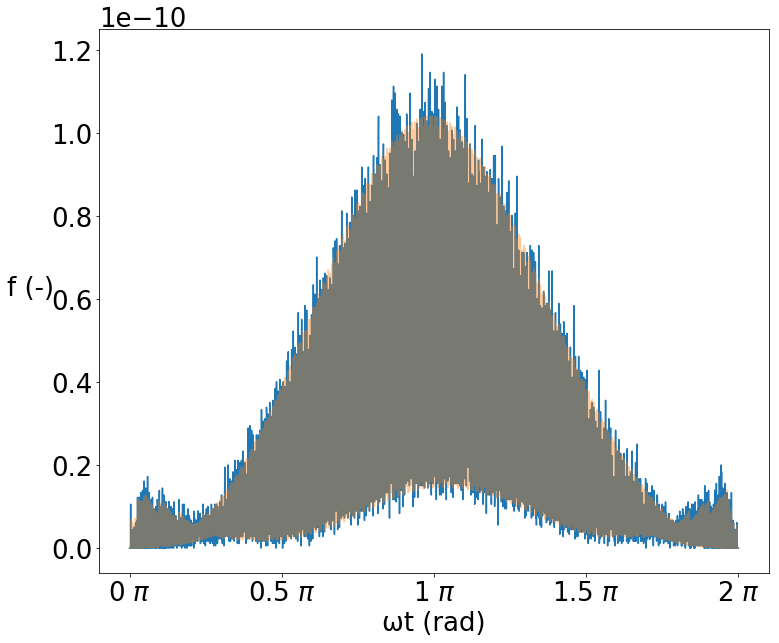

In [23]:
mpl.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(111)
plt.plot((time_array/year*360)/180,f_noisy,label='signal with shot noise')
plt.plot((time_array/year*360)/180,f_curve,alpha=0.4,label='noiseless signal')
# plt.legend()
# plt.plot(time_array/year,f_curve_edge_noisy,alpha=0.5)
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g $\pi$'))

plt.xlabel('ωt (rad)')
plt.ylabel('f (-)',rotation = 0,labelpad=20)
# plt.plot(f_curve_face,linewidth=0.1)
# plt.plot(f_curve_face_noisy,linewidth=0.1)
if burst:
    filename = 'f_curves/burstLCnoise'+ str(round(N_ave_full)) +'_seed'+str(seed_no)+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.png'
else:
    filename = 'f_curves/LCnoise'+ str(round(N_ave_full)) +'_seed'+str(seed_no)+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
plt.savefig(filename,bbox_inches='tight',dpi=100)
plt.show()


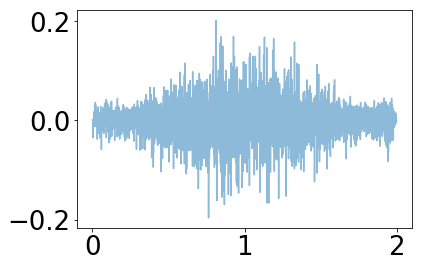

In [24]:
plt.plot((time_array/year*360)/180,(f_curve-f_noisy)/max(f_curve),alpha=0.5,label='noiseless signal')
plt.show()

In [25]:
%%time
'''
Compute inverse transfer matrix
'''
cutoff = 1/14
T_pinv = np.linalg.pinv(T,rcond=1e-7)
T_pinv_noise = np.linalg.pinv(T,rcond = cutoff)
A = np.matmul(T_pinv,f_curve)/c_light
A_noise = np.matmul(T_pinv_noise,f_noisy)/c_light



Wall time: 1min 16s


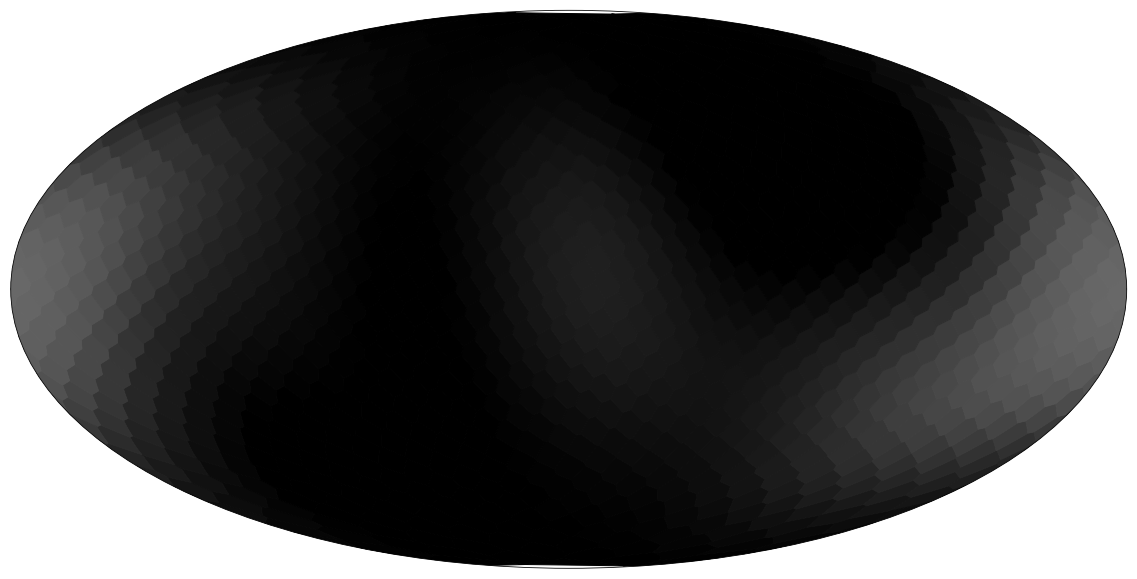

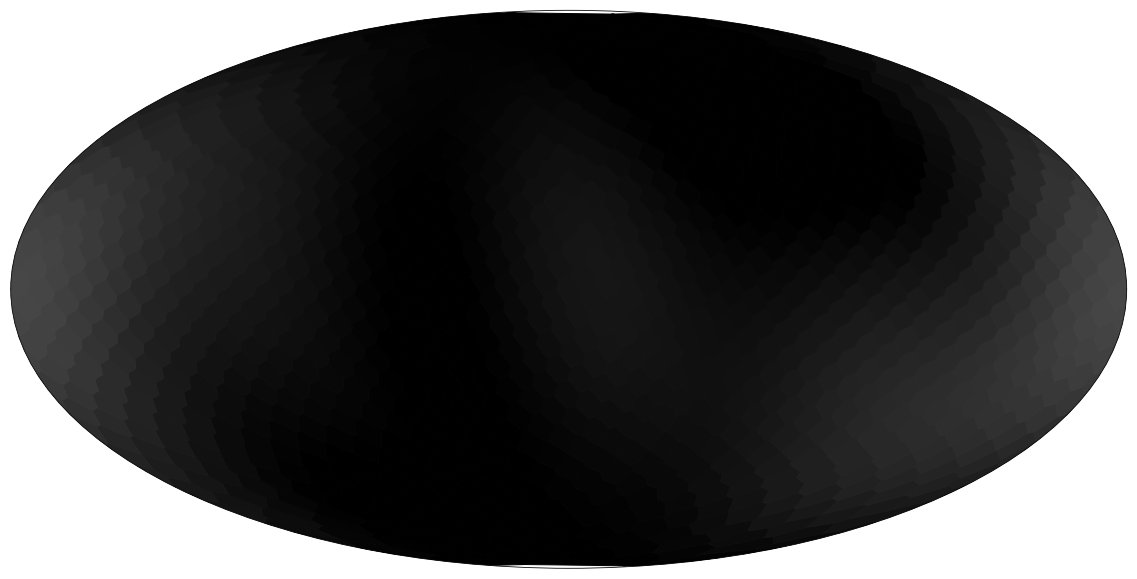

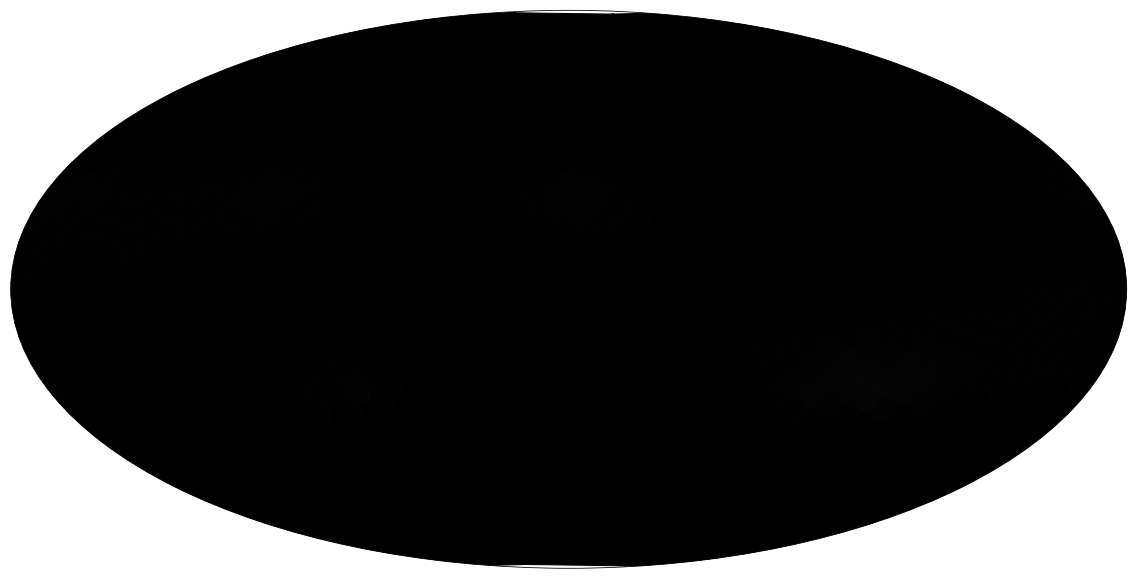

Wall time: 9.95 s


In [26]:
%%time
# plot every retrieved map, lambertian, lomsee and fresnel
mpl.rcParams.update({'font.size': 26})

fig1 = plt.figure(figsize = [20,20])
ax1 = fig1.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
cmapplot.set_array([])
# cb = fig1.colorbar(cmapplot, ax=ax1, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax1.add_collection(PolyCollection(plot_facets_vor,array=A_noise[:numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets
i=0
for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = greys(A_noise[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax1.set_xticklabels([])
ax1.set_yticklabels([])
model = models[0]
if burst:
    filename = 'retrieved_albedo_noise/burstnoise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_model'+model+'.png'
else:
    filename = 'retrieved_albedo_noise/noise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_model'+model+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig1.savefig(filename,dpi=100,bbox_inches='tight')

fig2 = plt.figure(figsize = [20,20])
ax2 = fig2.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
cmapplot.set_array([])
# cb = fig2.colorbar(cmapplot, ax=ax2, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax2.add_collection(PolyCollection(plot_facets_vor,array=A_noise[numpoints:2*numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets

for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = greys(A_noise[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax2.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax2.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax2.set_xticklabels([])
ax2.set_yticklabels([])
model = models[1]
if burst:
    filename = 'retrieved_albedo_noise/burstnoise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_model'+model+'.png'
else:
    filename = 'retrieved_albedo_noise/noise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_model'+model+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig2.savefig(filename,dpi=100,bbox_inches='tight')

fig3 = plt.figure(figsize = [20,20])
ax3 = fig3.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
cmapplot.set_array([])
# cb = fig3.colorbar(cmapplot, ax=ax3, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax3.add_collection(PolyCollection(plot_facets_vor,array=A_noise[numpoints*2:3*numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets

for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = greys(A_noise[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax3.set_xticklabels([])
ax3.set_yticklabels([])
model = models[2]
if burst:
    filename = 'retrieved_albedo_noise/burstnoise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_model'+model+'.png'
else:
    filename = 'retrieved_albedo_noise/noise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_model'+model+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig3.savefig(filename,dpi=100,bbox_inches='tight')

# plot every retrieved map, lambertian, lomsee and fresnel
# mpl.rcParams.update({'font.size': 26})

# fig4 = plt.figure(figsize = [20,20])
# ax4 = fig4.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
# cmapplot.set_array([])
# cb = fig4.colorbar(cmapplot, ax=ax4, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax4.add_collection(PolyCollection(plot_facets_vor,array=A[:numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets
# i=0
# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = greys(A[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax4.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax4.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax4.set_xticklabels([])
# model = models[0]
# if burst:
#     filename = 'retrieved_albedo_spectrum/burstspectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_model'+model+'.png'
# else:
#     filename = 'retrieved_albedo_spectrum/spectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_model'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig4.savefig(filename,dpi=100,bbox_inches='tight')

# fig5 = plt.figure(figsize = [20,20])
# ax5 = fig5.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
# cmapplot.set_array([])
# cb = fig5.colorbar(cmapplot, ax=ax5, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax5.add_collection(PolyCollection(plot_facets_vor,array=A[numpoints:2*numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets

# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = greys(A[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax5.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax5.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax5.set_xticklabels([])
# model = models[1]
# if burst:
#     filename = 'retrieved_albedo_spectrum/burstspectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_model'+model+'.png'
# else:
#     filename = 'retrieved_albedo_spectrum/spectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_model'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig5.savefig(filename,dpi=100,bbox_inches='tight')

# fig6 = plt.figure(figsize = [20,20])
# ax6 = fig6.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys)
# cmapplot.set_array([])
# cb = fig6.colorbar(cmapplot, ax=ax6, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax6.add_collection(PolyCollection(plot_facets_vor,array=A[numpoints*2:3*numpoints],cmap=greys,edgecolor='face',norm=norm)) #plot majority of facets

# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = greys(A[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax6.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax6.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax6.set_xticklabels([])
# model = models[2]
# if burst:
#     filename = 'retrieved_albedo_spectrum/burstspectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_model'+model+'.png'
# else:
#     filename = 'retrieved_albedo_spectrum/spectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_model'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig6.savefig(filename,dpi=100,bbox_inches='tight')

plt.show()

In [27]:
# %%time
# # plot each mean squared error, lambertian, lomsee and fresnel
# MSE = (albedo_map - A_noise)**2
# mpl.rcParams.update({'font.size': 26})
# cmap = mpl.cm.get_cmap('Greys',4000) #colors

# fig1 = plt.figure(figsize = [20,20])
# ax1 = fig1.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
# cmapplot.set_array([])
# cb = fig1.colorbar(cmapplot, ax=ax1, orientation='horizontal', label='MSE',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax1.add_collection(PolyCollection(plot_facets_vor,array=MSE[:numpoints],cmap=cmap,edgecolor='face',norm=norm)) #plot majority of facets
# i=0
# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = cmap(MSE[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax1.set_xticklabels([])
# model = models[0]
# if burst:
#     filename = 'retrieved_albedo_noise/burstnoiseseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_MSEmodel'+model+'.png'
# else:
#     filename = 'retrieved_albedo_noise/noise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_MSEmodel'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig1.savefig(filename,dpi=100,bbox_inches='tight')

# fig2 = plt.figure(figsize = [20,20])
# ax2 = fig2.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
# cmapplot.set_array([])
# cb = fig2.colorbar(cmapplot, ax=ax2, orientation='horizontal', label='MSE',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax2.add_collection(PolyCollection(plot_facets_vor,array=MSE[numpoints:2*numpoints],cmap=cmap,edgecolor='face',norm=norm)) #plot majority of facets

# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = cmap(MSE[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax2.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax2.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax2.set_xticklabels([])
# model = models[1]
# if burst:
#     filename = 'retrieved_albedo_noise/burstnoiseseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_MSEmodel'+model+'.png'
# else:
#     filename = 'retrieved_albedo_noise/noise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_MSEmodel'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig2.savefig(filename,dpi=100,bbox_inches='tight')

# fig3 = plt.figure(figsize = [20,20])
# ax3 = fig3.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
# cmapplot.set_array([])
# cb = fig3.colorbar(cmapplot, ax=ax3, orientation='horizontal', label='MSE',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax3.add_collection(PolyCollection(plot_facets_vor,array=MSE[numpoints*2:3*numpoints],cmap=cmap,edgecolor='face',norm=norm)) #plot majority of facets

# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = cmap(MSE[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax3.set_xticklabels([])
# model = models[2]
# if burst:
#     filename = 'retrieved_albedo_noise/burstnoiseseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_MSEmodel'+model+'.png'
# else:
#     filename = 'retrieved_albedo_noise/noise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'_MSEmodel'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig3.savefig(filename,dpi=100,bbox_inches='tight')

# # plot each mean squared error, lambertian, lomsee and fresnel
# MSE = (albedo_map - A)**2
# mpl.rcParams.update({'font.size': 26})
# cmap = mpl.cm.get_cmap('Greys',4000) #colors

# fig4 = plt.figure(figsize = [20,20])
# ax4 = fig4.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
# cmapplot.set_array([])
# cb = fig4.colorbar(cmapplot, ax=ax4, orientation='horizontal', label='MSE',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax4.add_collection(PolyCollection(plot_facets_vor,array=MSE[:numpoints],cmap=cmap,edgecolor='face',norm=norm)) #plot majority of facets
# i=0
# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = cmap(MSE[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax1.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax4.set_xticklabels([])
# model = models[0]
# if burst:
#     filename = 'retrieved_albedo_spectrum/burstspectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_MSEmodel'+model+'.png'
# else:
#     filename = 'retrieved_albedo_spectrum/spectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_MSEmodel'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig4.savefig(filename,dpi=100,bbox_inches='tight')

# fig5 = plt.figure(figsize = [20,20])
# ax5 = fig5.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
# cmapplot.set_array([])
# cb = fig5.colorbar(cmapplot, ax=ax5, orientation='horizontal', label='MSE',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax5.add_collection(PolyCollection(plot_facets_vor,array=MSE[numpoints:2*numpoints],cmap=cmap,edgecolor='face',norm=norm)) #plot majority of facets

# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = cmap(MSE[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax5.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax5.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax5.set_xticklabels([])
# model = models[1]
# if burst:
#     filename = 'retrieved_albedo_spectrum/burstspectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_MSEmodel'+model+'.png'
# else:
#     filename = 'retrieved_albedo_spectrum/spectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_MSEmodel'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig5.savefig(filename,dpi=100,bbox_inches='tight')

# fig6 = plt.figure(figsize = [20,20])
# ax6 = fig6.add_subplot(111,projection='mollweide')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
# cmapplot.set_array([])
# cb = fig6.colorbar(cmapplot, ax=ax6, orientation='horizontal', label='MSE',shrink=1/1.5, aspect=40,pad=-0.6)

# # plot the facets
# ax6.add_collection(PolyCollection(plot_facets_vor,array=MSE[numpoints*2:3*numpoints],cmap=cmap,edgecolor='face',norm=norm)) #plot majority of facets

# for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
#     c = cmap(MSE[i])
#     if np.any(facet_sph[:,0]>np.pi):
#         ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax3.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
#     i+=1

# ax6.set_xticklabels([])
# model = models[2]
# if burst:
#     filename = 'retrieved_albedo_spectrum/burstspectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_MSEmodel'+model+'.png'
# else:
#     filename = 'retrieved_albedo_spectrum/spectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_MSEmodel'+model+'.png'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# fig6.savefig(filename,dpi=100,bbox_inches='tight')

# plt.show()

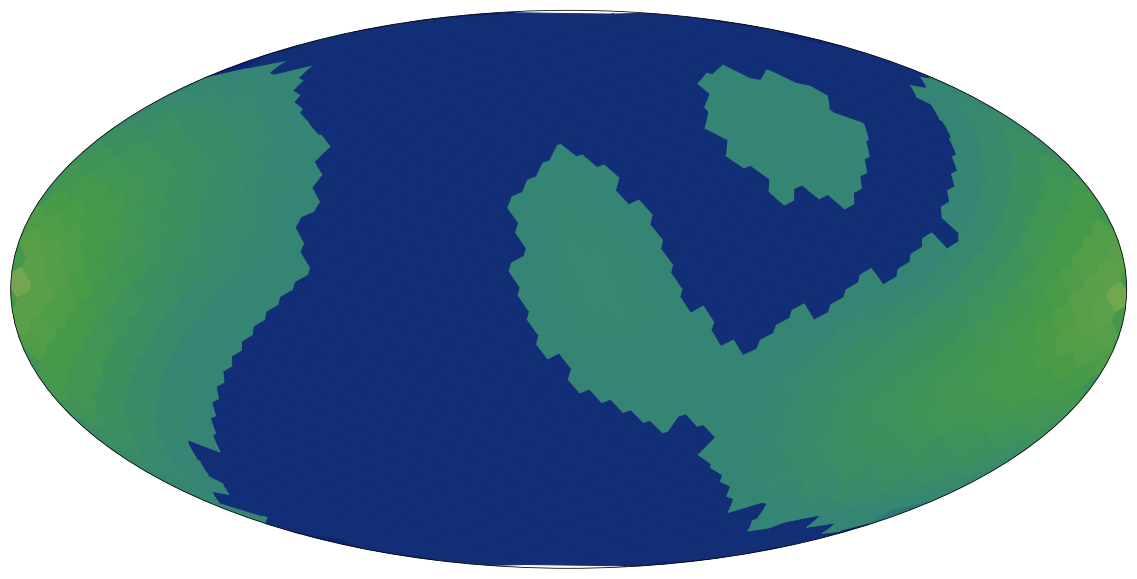

Wall time: 3.36 s


In [28]:
%%time
facet_albedos = np.array([A_noise[:numpoints],A_noise[numpoints:2*numpoints],A_noise[2*numpoints:]]).transpose() #albedos_1d of each facet for every model
albedos = np.array([[0,0,1],[0.2,0,0],[0,0.4,0],[0.75,0,0]])

# minimize distance from retrieved albedo to the surface types
tree_dist, facet_types = KDTree(albedos).query(facet_albedos) #the surface type of the retrieved facet, 0 for water, 1 vegetation, 2 desert, 3 snow
facet_types[np.where(np.linalg.norm(facet_albedos - [0,0,0],axis=1)<0.075)] = 0

type_albedo = np.empty(numpoints)


# for i in np.arange(numpoints):
#     type_albedo[i] = np.linalg.norm(facet_albedos[i])
#     print(i,type_albedo[i],facet_albedos[i])

type_albedo[np.where(facet_types == 0)[0]] = 0.05
type_albedo[np.where(facet_types == 1)[0]] = 0.1+ np.clip((np.linalg.norm(facet_albedos[np.where(facet_types == 1)[0]],axis=1)-0.1)/0.3,0,1)*0.2
type_albedo[np.where(facet_types == 2)[0]] = 0.31+ np.clip((np.linalg.norm(facet_albedos[np.where(facet_types == 2)[0]],axis=1)-0.3)/0.2,0,1)*0.2
type_albedo[np.where(facet_types == 3)[0]] = 0.5+ np.clip((np.linalg.norm(facet_albedos[np.where(facet_types == 3)[0]],axis=1)-0.5)/0.3,0,1)*0.3

# gist_earth = mpl.cm.get_cmap('gist_earth',4000)
# type_colors = np.array([gist_earth(0.1),gist_earth(0.4),gist_earth(.8),gist_earth(1)])

albedos_1d = np.array([0.06,0.15,0.4,0.8])


gist_earth = mpl.cm.get_cmap('gist_earth',4000) #colors
N = 256
y1 = gist_earth(np.linspace(0.02,0.15,int(N*0.08))) #ocean colors
y2 = gist_earth(np.linspace(0.3,0.5,int(N*0.22))) #forest colors
y3 = gist_earth(np.linspace(0.7,0.85,int(N*0.2))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N*.3))) #snow colors
y = np.vstack((y1,y2,y3,y4))

cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0,vmax=0.8)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
cmapplot.set_array([])
# cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='Albedo?',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax.add_collection(PolyCollection(plot_facets_vor,array=type_albedo,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
i=0
for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = cmap_albedo(type_albedo[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax.set_xticklabels([])
ax.set_yticklabels([])
if burst:
    filename = 'retrieved_albedo_noise/burstnoise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'.png'
else:
    filename = 'retrieved_albedo_noise/noise'+ str(round(N_ave_full)) +'seed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoff{:.0e}'.format(cutoff)+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig.savefig(filename,dpi=100,bbox_inches='tight')
plt.show()




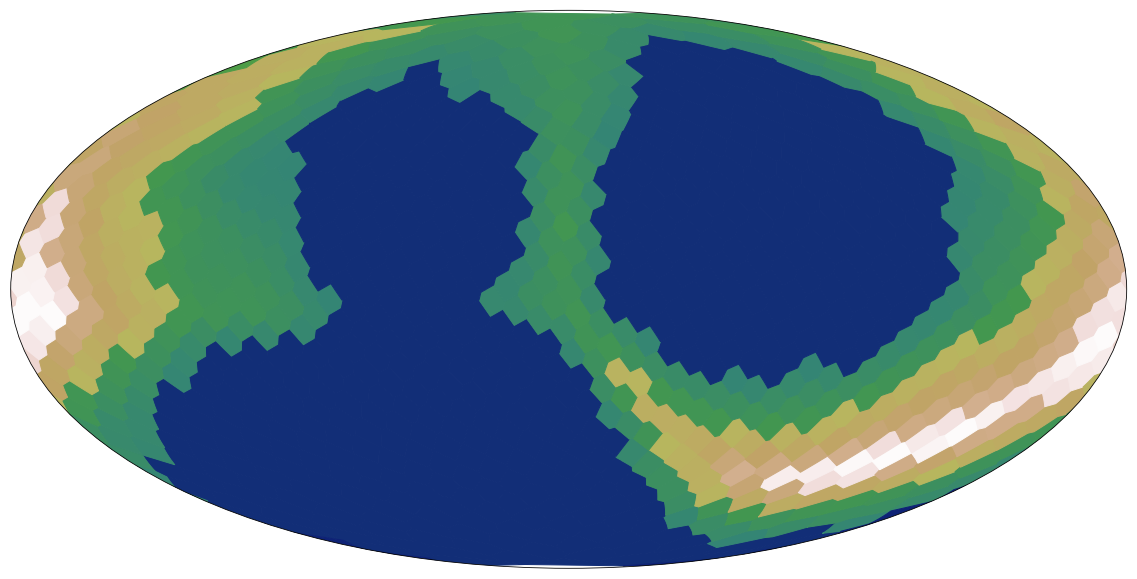

Wall time: 3.36 s


In [29]:
%%time
A = albedo_map
facet_albedos = np.array([A[:numpoints],A[numpoints:2*numpoints],A[2*numpoints:]]).transpose() #albedos_1d of each facet for every model
albedos = np.array([[0,0,1],[0.2,0,0],[0,0.4,0],[0.75,0,0]])

# minimize distance from retrieved albedo to the surface types
tree_dist, facet_types = KDTree(albedos).query(facet_albedos) #the surface type of the retrieved facet, 0 for water, 1 vegetation, 2 desert, 3 snow
facet_types[np.where(np.linalg.norm(facet_albedos - [0,0,0],axis=1)<0.075)] = 0

type_albedo = np.empty(numpoints)


# for i in np.arange(numpoints):
#     type_albedo[i] = np.linalg.norm(facet_albedos[i])
#     print(i,type_albedo[i],facet_albedos[i])

type_albedo[np.where(facet_types == 0)[0]] = 0.05
type_albedo[np.where(facet_types == 1)[0]] = 0.1+ np.clip((np.linalg.norm(facet_albedos[np.where(facet_types == 1)[0]],axis=1)-0.1)/0.3,0,1)*0.2
type_albedo[np.where(facet_types == 2)[0]] = 0.3+ np.clip((np.linalg.norm(facet_albedos[np.where(facet_types == 2)[0]],axis=1)-0.3)/0.2,0,1)*0.2
type_albedo[np.where(facet_types == 3)[0]] = 0.5+ np.clip((np.linalg.norm(facet_albedos[np.where(facet_types == 3)[0]],axis=1)-0.5)/0.3,0,1)*0.3

# gist_earth = mpl.cm.get_cmap('gist_earth',4000)
# type_colors = np.array([gist_earth(0.1),gist_earth(0.4),gist_earth(.8),gist_earth(1)])

albedos_1d = np.array([0.06,0.15,0.4,0.8])


gist_earth = mpl.cm.get_cmap('gist_earth',4000) #colors
N = 256
y1 = gist_earth(np.linspace(0.02,0.15,int(N*0.08))) #ocean colors
y2 = gist_earth(np.linspace(0.3,0.5,int(N*0.22))) #forest colors
y3 = gist_earth(np.linspace(0.7,0.85,int(N*0.2))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N*.3))) #snow colors
y = np.vstack((y1,y2,y3,y4))

cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0,vmax=0.8)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
cmapplot.set_array([])
# cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='Albedo?',shrink=1/1.5, aspect=40,pad=-0.6)

# plot the facets
ax.add_collection(PolyCollection(plot_facets_vor,array=type_albedo,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
i=0
for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = cmap_albedo(type_albedo[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax.set_xticklabels([])
ax.set_yticklabels([])
# if burst:
#     filename = 'retrieved_albedo_spectrum/burstspectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoffe'+str(round(np.log(cutoff)/np.log(10)))+'.png'
# else:
#     filename = 'retrieved_albedo_spectrum/spectrseed'+str(seed_no)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+ '_t'+ str(time_res) +'_n'+str(numpoints)+'_cutoffe'+str(round(np.log(cutoff)/np.log(10)))+'.png'
filename = 'surfacemaprange'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
fig.savefig(filename,dpi=100,bbox_inches='tight')
plt.show()


